In [1]:
import os
import re
import numpy as np
import pandas as pd
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold

from imblearn.over_sampling import RandomOverSampler, SMOTE

from gensim.models import KeyedVectors

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.callbacks import EarlyStopping
from keras.utils import Sequence

from multilabel import MultiLabelClassification

Using TensorFlow backend.


# Data

In [2]:
df = pd.read_csv('songs-ml-10pct.csv')
X = df.pop('lyrics').values
y = df.values
genres = df.columns
print(f"number of songs: {X.shape[0]}")
print(f"number of labels: {y.shape[1]}")
print(f"labels: {list(genres)}")

number of songs: 60964
number of labels: 5
labels: ['black', 'death', 'heavy', 'power', 'thrash']


# Word2Vec model

### Create and save Word2Vec model

In [59]:
# sentences = df.lyrics.str.split().tolist()
# word2vec_model = Word2Vec(sentences, size=400, window=5, min_count=5, workers=multiprocessing.cpu_count())
# word2vec_model.save('word2vec.model')

### Load untrained model

In [60]:
# word2vec_model = Word2Vec.load('word2vec.model')
# word_vectors = word2vec_model.wv
# del word2vec_model

### Train and save trained model

In [12]:
# sentences_train = [doc.split() for doc in df.lyrics.values]
# word2vec_model = Word2Vec(sentences_train, size=400, window=3, min_count=20, workers=multiprocessing.cpu_count())
# word2vec_model.save('word2vec_train.model')

# Convolutional Neural Network

In [3]:
def create_keras_model(embedding_matrix, input_length, nb_classes=1, conv_nb_filters=(64,), conv_kernel_size=(5,), fc_size=(64,)):
    keras_model = Sequential()
    keras_model.add(layers.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], input_length=input_length, trainable=False))
    if len(conv_nb_filters) != len(conv_kernel_size):
        raise ValueError("n_conv_filters and conv_size must be same length")
    for nb_filters, kernel_size in zip(conv_nb_filters, conv_kernel_size):
        keras_model.add(layers.Conv1D(nb_filters, kernel_size, activation='relu'))
        keras_model.add(layers.MaxPooling1D(2))
    keras_model.add(layers.Flatten())
    for fc_size_ in fc_size:
        keras_model.add(layers.Dense(fc_size_, activation='relu'))
    keras_model.add(layers.Dense(nb_classes, activation='sigmoid'))
    keras_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    return keras_model


class BatchGenerator(Sequence):

    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.X) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_X = self.X[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_X, batch_y

### Cross-validation training

In [4]:
def preprocess_data(corpus_train, corpus_valid, word2vec_model=None, word_vectors=None):
    maxlen = max([len(doc.split()) for doc in corpus_train])
    word_vectors = get_word_vectors(word2vec_model=word2vec_model, word_vectors=word_vectors)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus_train)
    X_train = tokenizer.texts_to_sequences(corpus_train)
    X_valid = tokenizer.texts_to_sequences(corpus_valid)
    X_train = pad_sequences(X_train, maxlen=maxlen, padding='post')
    X_valid = pad_sequences(X_valid, maxlen=maxlen, padding='post')
    embedding_matrix = generate_word_embedding(tokenizer, word_vectors)
    return X_train, X_valid, embedding_matrix


def get_word_vectors(word2vec_model=None, word_vectors=None):
    if word2vec_model is not None:
        if isinstance(word2vec_model, str):
            if os.path.exists(word2vec_model):
                w2v = Word2Vec.load(word2vec_model)
            else:
                w2v = gensim_api.load(word2vec_model)
        else:
            w2v = word2vec_model
        word_vectors = w2v.wv
    elif word_vectors is not None:
        pass
    else:
        raise ValueError("must provide one of word2vec_model or word_vectors")
    return word_vectors


def generate_word_embedding(tokenizer, word_vectors):
    vocab_size = len(tokenizer.word_index) + 1
    vector_dim = word_vectors.vector_size
    embedding_matrix = np.zeros((vocab_size, vector_dim))
    for word, word_idx in tokenizer.word_index.items():
        try:
            embedding_vector = word_vectors[word]
        except KeyError:
            pass
        else:
            embedding_matrix[word_idx] = embedding_vector
    return embedding_matrix

Loading Word2Vec model
Performing 3-fold cross-validation
-----
CV fold 1/3
Epoch 1/1
40/40 [==============================] - 245s 6s/step - loss: 0.5307 - binary_accuracy: 0.7826 - val_loss: 0.4740 - val_binary_accuracy: 0.7953
-----
CV fold 2/3
Epoch 1/1
40/40 [==============================] - 240s 6s/step - loss: 0.5287 - binary_accuracy: 0.7798 - val_loss: 0.4562 - val_binary_accuracy: 0.7908
-----
CV fold 3/3
Epoch 1/1
40/40 [==============================] - 168s 4s/step - loss: 0.5320 - binary_accuracy: 0.7810 - val_loss: 0.4739 - val_binary_accuracy: 0.7935
Multi-label classification report:
Accuracy:      0.17
Precision:     0.20
Recall:        0.39
F1-score:      0.27


D:\Projects\metallyrics\multilabel.py:118: RuntimeWarning: invalid value encountered in true_divide
  return np.nanmean(self.__intersection.sum(1) / self.__union.sum(1))
D:\Projects\metallyrics\multilabel.py:123: RuntimeWarning: invalid value encountered in true_divide
  return np.nanmean(self.__intersection.sum(1) / self.pred_classes.sum(1))
D:\Projects\metallyrics\multilabel.py:128: RuntimeWarning: invalid value encountered in true_divide
  return np.nanmean(self.__intersection.sum(1) / self.true.sum(1))


Hamming loss:  2.25


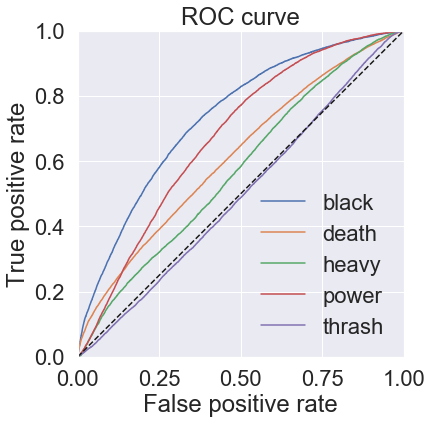

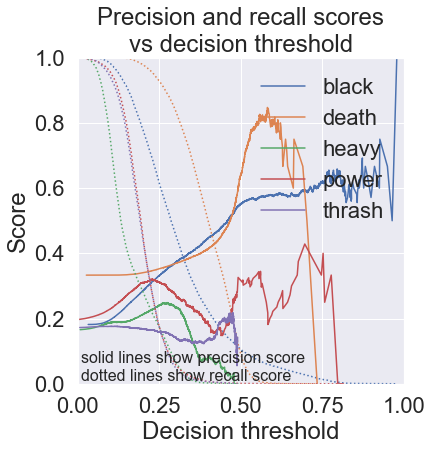

[0.73496833 0.614226   0.57180614 0.67487839 0.4953407 ]
AUC ROC score: 0.62 +/- 0.08
Best thresholds:
black     : 0.23
death     : 0.38
heavy     : 0.12
power     : 0.17
thrash    : 0.19
Multi-label classification report:
Accuracy:      0.24
Precision:     0.29
Recall:        0.61
F1-score:      0.39


D:\Projects\metallyrics\multilabel.py:118: RuntimeWarning: invalid value encountered in true_divide
  return np.nanmean(self.__intersection.sum(1) / self.__union.sum(1))
D:\Projects\metallyrics\multilabel.py:123: RuntimeWarning: invalid value encountered in true_divide
  return np.nanmean(self.__intersection.sum(1) / self.pred_classes.sum(1))
D:\Projects\metallyrics\multilabel.py:128: RuntimeWarning: invalid value encountered in true_divide
  return np.nanmean(self.__intersection.sum(1) / self.true.sum(1))


Hamming loss:  2.15
-----
Cross-validation complete
CV score: 58.45% +/- 12.91%
Average confusion matrix:
[[[0.10915622 0.05446493]
  [0.01137393 0.02500492]]

 [[0.07840037 0.05497015]
  [0.0292238  0.03740568]]

 [[0.08609671 0.08074929]
  [0.01432649 0.0188275 ]]

 [[0.09074864 0.06981169]
  [0.01179385 0.02764582]]

 [[0.07778033 0.08773046]
  [0.01650482 0.01798438]]]


In [29]:
# Dataset
nb_classes = y.shape[1]

# Word2vec model
print("Loading Word2Vec model")
# word2vec_model = Word2Vec.load('word2vec_train.model')
# word_vectors = word2vec_model.wv
# del word2vec_model
word_vectors = KeyedVectors.load('glove-wiki-gigaword-300')

# Cross-validation
n_splits = 3
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=0)

# CNN model
model_params = dict(
    nb_classes=nb_classes,
    conv_nb_filters=(32,),
    conv_kernel_size=(4,),
    fc_size=(128,)
)

# Training
epochs = 1
batch_size = 1024

scores = np.zeros((n_splits, nb_classes))
confusion_matrices = np.zeros((n_splits, nb_classes, 2, 2))
results = []
print("Performing {}-fold cross-validation".format(n_splits))
for i, (train_idx, valid_idx) in enumerate(kfold.split(X, y)):
    print("-----\nCV fold {}/{}".format(i + 1, n_splits))
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    X_train, X_valid, embedding_matrix = preprocess_data(X_train, X_valid, word_vectors=word_vectors)
    keras_model = create_keras_model(embedding_matrix, X_train.shape[1], **model_params)
    train_generator  = BatchGenerator(X_train, y_train, batch_size)
    validation_generator = BatchGenerator(X_valid, y_valid, batch_size)
    keras_model.fit_generator(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)],
    )
    y_pred = keras_model.predict(X_valid)
    results.append((y_valid, y_pred))
true = np.concatenate([res[0] for res in results])
pred = np.concatenate([res[1] for res in results])

mlc = MultiLabelClassification(true, pred, y_pred_classes=pred_classes, labels=genres)
mlc.print_report()
mlc.plot_roc_curve()
plt.show()
mlc.plot_precision_recall_curve()
plt.show()
auc_scores = mlc.roc_auc_score()
print(auc_scores)
print("AUC ROC score: {:.2f} +/- {:.2f}".format(np.mean(auc_scores), np.std(auc_scores)))
best_thresholds = mlc.best_thresholds()
print("Best thresholds:")
for i, label in enumerate(mlc.labels):
    print(f"{label:<10s}: {best_thresholds[i]:.2f}")

pred_classes = np.zeros(pred.shape).astype(int)
for i in range(nb_classes):
    pred_classes[:, i] = (pred[:, i] > best_thresholds[i])

mlc = MultiLabelClassification(true, pred, y_pred_classes=pred_classes, labels=genres)
mlc.print_report()
scores = np.zeros((n_splits, nb_classes))
confusion_matrices = np.zeros((n_splits, nb_classes, 2, 2))
for i, (train_idx, valid_idx) in enumerate(kfold.split(X, y)):
    for j in range(nb_classes):
        scores[i, j] = balanced_accuracy_score(true[valid_idx, j], pred_classes[valid_idx, j])
        confusion_matrices[i, j] = confusion_matrix(true[valid_idx, j], pred_classes[valid_idx, j])
print("-----\nCross-validation complete")
print("CV score: {:.2f}% +/- {:.2f}%".format(scores.mean() * 100, scores.std() * 200))
print("Average confusion matrix:")
print(confusion_matrices.mean(axis=0) / confusion_matrices.sum() * n_splits)